# Data clean

This script should be used to clean and format raw data for processing in CCM_analysis

for 01_ccm_analysis_v8

In [1]:
# Wrangling
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import seaborn as sns
import scipy.stats as sps
import matplotlib.cm as cm
import matplotlib.patches as mpatches

# Mapping
import cartopy.crs as ccrs
import cartopy.feature as cfeature
#import plotly.express as px
#import plotly.graph_objects as go
#import geopandas as gpd
#from geopandas import GeoDataFrame

## Functions

In [2]:
# Normalize column data
def normalize(data, method=1):
    ts = data[~np.isnan(data)]
    if method == 1: # Normalize by maximum differences
        return (data - np.min(ts)) / (np.max(ts) - np.min(ts))
    elif method == 2: # Normalize by standard deviation
        return (data - np.mean(ts)) / np.std(ts)


# Add time step column (not equivalent to the date)
def add_time(data, datecolumn):
    data[datecolumn] = data.index
    cols = data.columns.tolist()
    data = data[[cols[-1]] + cols[:-1]]
    return data


# Change month in datetime value to be the first month of the quarter/season
def reset_to_quarter_start(dt):
    month = ((dt.month - 1) // 3) * 3 + 1
    return pd.Timestamp(year=dt.year, month=month, day=1)


def deseasonalize_by_index_period(df, period_length=12):
    """
    Remove repeating seasonal cycle from a DataFrame where each row is regularly spaced in time.

    Parameters
    ----------
    df : pd.DataFrame
        Time series data where rows are ordered (e.g., monthly or seasonal observations).
        Assumes no time column—just one column per variable.
    period_length : int
        Length of the repeating seasonal cycle (e.g., 12 for months, 4 for seasons).

    Returns
    -------
    pd.DataFrame
        DataFrame of anomalies with the same shape and index.
    """
    df = df.copy()
    cycle_index = np.arange(len(df)) % period_length

    anomalies = df.copy()
    for col in df.columns:
        seasonal_means = df.groupby(cycle_index)[col].transform('mean')
        anomalies[col] = df[col] - seasonal_means

    return anomalies

# Species

In [3]:
species_key = pd.read_csv("../../data/species_key.csv")
print(species_key.head())

# Function to replace species names with a reference name from species_key
def replace_species_with_reference(df, species_key, column=None, axis='columns'):
    """
    Replaces species names in a dataframe with reference names using a species key.

    Parameters:
    - df: The DataFrame to modify
    - species_key: A DataFrame with 'common_name', 'scientific_name', 'reference_name'
    - column: (optional) If replacing cell values in a specific column, provide the column name.
    - axis: 'columns' if replacing column names, 'index' if replacing index names (only if column=None)

    Returns:
    - Modified DataFrame with names replaced by reference_name

    Examples:
    df = replace_species_with_reference(df, species_key, column='species') # Replace values in a column
    df = replace_species_with_reference(df, species_key)                   # Replace column names
    df = replace_species_with_reference(df, species_key, axis='index')     # Replace index values (e.g., if species names are in the index)
    """
    name_map = dict()

    for _, row in species_key.iterrows():
        name_map[row['common_name']] = row['reference_name']
        name_map[row['scientific_name']] = row['reference_name']

    if column is not None:
        df[column] = df[column].map(name_map).fillna(df[column])
    else:
        if axis == 'columns':
            df = df.rename(columns=name_map)
        elif axis == 'index':
            df.index = df.index.map(lambda x: name_map.get(x, x))

    return df

         common_name         scientific_name    reference_name
0  Anchovy, northern        Engraulis mordax  anchovy_northern
1   Sardine, Pacific         Sardinops sagax   sardine_pacific
2  Mackerel, Pacific       Scomber japonicus  mackerel_pacific
3     Mackerel, jack   Trachurus symmetricus     mackerel_jack
4      Squid, market  Doryteuthis opalescens      squid_market


# California Dept of Fish & Wildlife (CDFW) commercial catches

## Statewide CDFW for all species

In [4]:
# Load the Excel file
df = pd.read_excel("../../data/raw/CDFW/CDFW_landings_statewide.xlsx")

In [5]:
# Replace 'Confidential' with 0 and convert columns to numeric
df['Pounds'] = pd.to_numeric(df['Pounds'], errors='coerce').fillna(0).astype(int)
df['Value'] = pd.to_numeric(df['Value'], errors='coerce').fillna(0).astype(int)

# Create a datetime column for grouping
df['Date'] = pd.to_datetime(df[['Year', 'Month']].assign(DAY=1))

# Group by Date and Species Name and sum over all blocks
grouped_pounds = df.groupby(['Date', 'Species Name'])['Pounds'].sum().unstack(fill_value=0)
grouped_value = df.groupby(['Date', 'Species Name'])['Value'].sum().unstack(fill_value=0)

# Optional: sort Date index
grouped_pounds = grouped_pounds.sort_index()
grouped_value = grouped_value.sort_index()

# Reindex
grouped_pounds = grouped_pounds#.reset_index().rename_axis(None, axis=1)
grouped_value = grouped_value#.reset_index().rename_axis(None, axis=1)

grouped_pounds

Species Name,Abalone,"Abalone, black","Abalone, flat","Abalone, green","Abalone, pink","Abalone, pinto","Abalone, red","Abalone, threaded","Abalone, white",Agar,...,Turtle,Unspecified,Wahoo,"Whelk, Kellet's","Whitefish, ocean","Whiting, Pacific","Worms, marine","Wrasse, rock",Yellowtail,Zebraperch
Date,,,,,,,,,,,,,,,,,,,,,
1980-01-01,0,36851,0,5690,14264,0,36533,0,318,0,...,0,0,0,0,0,0,0,0,15396,0
1980-02-01,0,2954,0,831,394,0,0,0,0,0,...,0,0,0,0,0,0,0,0,34233,0
1980-03-01,0,33902,0,6498,21306,0,57107,0,0,0,...,0,0,0,0,0,0,0,0,15749,0
1980-04-01,0,19618,0,4715,20104,0,39090,0,0,0,...,0,0,0,0,0,0,0,0,20498,0
1980-05-01,0,30204,0,10229,17252,0,53606,0,0,0,...,0,0,0,0,0,0,0,0,11121,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-01,0,0,0,0,0,0,0,0,0,0,...,0,0,0,2956,1295,149,0,0,5897,0
2024-09-01,0,0,0,0,0,0,0,0,0,0,...,0,0,2971,2506,3216,88,0,0,1399,0
2024-10-01,0,0,0,0,0,0,0,0,0,0,...,0,0,0,5921,4641,0,0,0,975,0


Plot

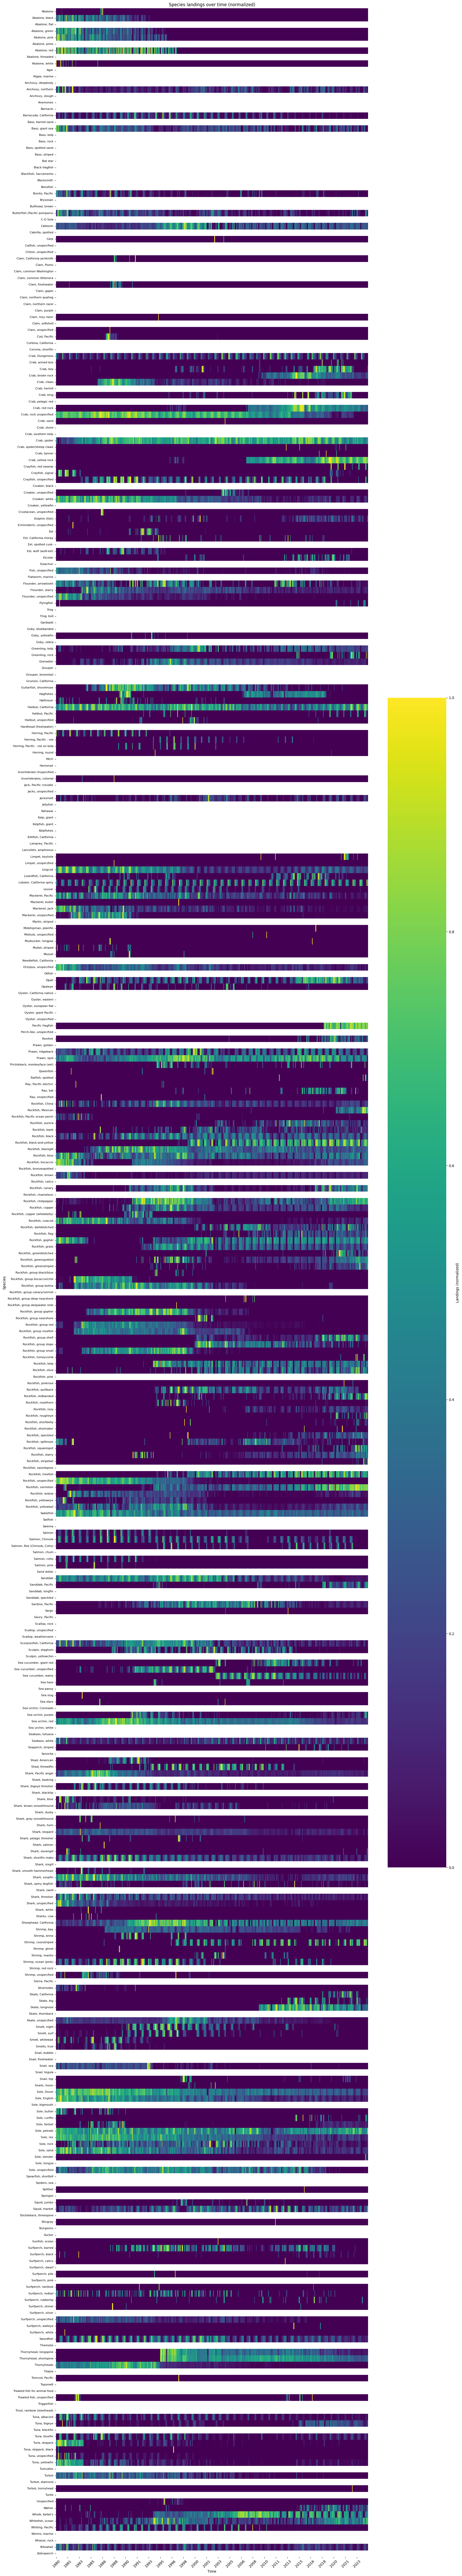

In [6]:
heatmap_data = grouped_pounds.apply(lambda x: np.sqrt(normalize(x, method=1)), axis = 0)

# Transpose so species are rows and time is columns
heatmap_data = heatmap_data.T

# Plot
fig, ax = plt.subplots(1, sharex=True)
sns.heatmap(heatmap_data, cmap='viridis', cbar_kws={'label': 'Landings (normalized)'}, ax=ax, yticklabels=True)
ax.set_xlabel("Time")
ax.set_ylabel("Species")
ax.set_title("Species landings over time (normalized)")

# Format x-axis to show only the year
ax.set_xticklabels([label.get_text()[:4] for label in ax.get_xticklabels()], rotation=45)
ax.set_yticks(np.arange(heatmap_data.shape[0]) + 0.5)  # one tick per row
ax.set_yticklabels(heatmap_data.index, rotation=0, fontsize=8)  # or rotation=45, fontsize as needed

fig.set_size_inches(18, 100)
plt.tight_layout()
plt.show()

Specify data of interest

In [7]:
grouped_pounds_renamed = replace_species_with_reference(grouped_pounds, species_key)
grouped_value_renamed = replace_species_with_reference(grouped_value, species_key)

#data_of_interest = grouped_pounds_renamed[['Anchovy, northern', 'Sardine, Pacific', 'Mackerel, Pacific', 'Mackerel, jack', 'Squid, market', 'Whiting, Pacific']]
data_of_interest = grouped_pounds_renamed[['anchovy_northern',
                                           'sardine_pacific',
                                           'mackerel_pacific',
                                           'mackerel_jack',
                                           'squid_market',
                                           'whiting_pacific']]

Process at different scales

In [8]:
# Monthly
data = data_of_interest

#data = deseasonalize_anomalies_fixed_period(data, 'monthly')
#data = data.diff().dropna()
data = data.apply(lambda x: np.sqrt(normalize(x, method=1)), axis = 0)
#data = data.apply(lambda x: normalize(x, method=2), axis = 0)

#data.to_pickle("../../data_out/" + "cdfw_landings" + "_monthly.pkl")
#data.to_pickle("../../data_out/" + "cdfw_value" + "_monthly.pkl")

In [9]:
data

Species Name,anchovy_northern,sardine_pacific,mackerel_pacific,mackerel_jack,squid_market,whiting_pacific
Date,,,,,,
1980-01-01,0.336150,0.000000,0.678446,0.863366,0.188699,0.000000
1980-02-01,0.026000,0.000000,0.420828,0.478707,0.131066,0.000000
1980-03-01,0.023812,0.000000,0.357839,0.402512,0.000000,0.000000
1980-04-01,0.669361,0.000000,0.413721,0.602035,0.000000,0.000000
1980-05-01,0.647773,0.000000,0.552229,0.600928,0.040338,0.000000
...,...,...,...,...,...,...
2024-08-01,0.033404,0.112904,0.226281,0.039941,0.204699,0.003728
2024-09-01,0.130340,0.097666,0.100067,0.040040,0.138132,0.002865
2024-10-01,0.070797,0.085089,0.046504,0.054298,0.341751,0.000000


In [10]:
# Seasonally
data = data_of_interest.copy()  # <-- this avoids the view vs. copy warning
data['quarter_start'] = data.index.map(reset_to_quarter_start)
data = data.groupby('quarter_start').sum()

#data = data.diff().dropna()
data = data.apply(lambda x: np.sqrt(normalize(x, method=1)), axis=0)
#data = data.apply(lambda x: normalize(x, method=1), axis=0)
data = data.apply(lambda x: normalize(x, method=2), axis=0)
data.index.name = 'Date'

data.to_pickle("../../data_out/" + "cdfw_landings" + "_seasonally.pkl")
#data.to_pickle("../../data_out/" + "cdfw_value" + "_seasonally.pkl")

In [11]:
# Annually
data = data_of_interest
data = data.groupby(data.index.year).sum()

#data = data.diff().dropna()
data = data.apply(lambda x: np.sqrt(normalize(x, method=1)), axis = 0)
#data = data.apply(lambda x: normalize(x, method=2), axis = 0)

data.to_pickle("../../data_out/" + "cdfw_landings" + "_annually.pkl")
#data.to_pickle("../../data_out/" + "cdfw_value" + "_annually.pkl")

In [12]:
# Annually, spring only
data = data_of_interest
data = data[data.index.month == 4]
data = data.groupby(data.index.year).sum()

#data = data.diff().dropna()
#data = data.apply(lambda x: np.sqrt(normalize(x, method=1)), axis = 0)
data = data.apply(lambda x: normalize(x, method=2), axis = 0)

#data.to_pickle("../../data_out/" + "cdfw_landings" + "_annually.pkl")
#data.to_pickle("../../data_out/" + "cdfw_value" + "_annually.pkl")

<Axes: xlabel='Date'>

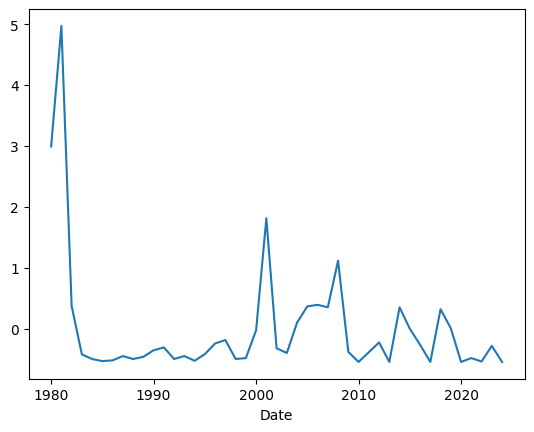

In [13]:
data['anchovy_northern'].plot()

In [14]:
# Assuming df is your DataFrame with time series as columns
skew_values = data.skew()

# Print skewness for each column
print(skew_values)

Species Name
anchovy_northern    3.554301
sardine_pacific     1.554315
mackerel_pacific    2.677881
mackerel_jack       3.058766
squid_market        1.517887
whiting_pacific     1.527030
dtype: float64


# CalCOFI

In [15]:
# Load the data
df = pd.read_csv("../../data/raw/CalCOFI/CALCOFI_fish_larvae_ichthyoplankton_20191201.csv")

In [ ]:
df['Date'] = pd.to_datetime(df['cruise'].astype(str) + '01', format='%Y%m%d')

# Apply function to create a new quarter-start column
df['quarter_start'] = df['Date'].map(reset_to_quarter_start)

# Group by quarter and species, then average
grouped = df.groupby(['quarter_start', 'scientific_name'])['larvae_10m2'].mean().reset_index()

# Pivot to wide format: rows = time, columns = species
grouped_larvae = grouped.pivot(index='quarter_start', columns='scientific_name', values='larvae_10m2')

# Generate full range of expected quarter-start dates
full_quarters = pd.date_range(start=grouped_larvae.index.min(), end=grouped_larvae.index.max(), freq='QS')

# Reindex to include all expected dates, filling with NaN where missing
grouped_larvae = grouped_larvae.reindex(full_quarters)

# Rename index
grouped_larvae.index.name = 'Date'

grouped_larvae

Specify data of interest

In [ ]:
grouped_larvae_renamed = replace_species_with_reference(grouped_larvae, species_key)

#data_of_interest = grouped_larvae_renamed[['Sardinops sagax', 'Engraulis mordax', 'Trachurus symmetricus', 'Merluccius productus']]
data_of_interest = grouped_larvae_renamed[['anchovy_northern',
                                           'sardine_pacific',
                                           'mackerel_pacific',
                                           'mackerel_jack',
                                           #'squid_market',
                                           'whiting_pacific']]

Process at different scales

In [ ]:
# Seasonally
data = data_of_interest

#data = data.diff().dropna()
data = data.apply(lambda x: np.sqrt(normalize(x, method=1)), axis = 0)
#data = data.apply(lambda x: normalize(x, method=2), axis = 0)

#data.to_pickle("../../data_out/" + "calcofi_larvae" + "_seasonally.pkl")

In [ ]:
# Annually
data = data_of_interest
data = data.groupby(data.index.year).mean()
data = data[data.index > 1983]

#data = data.diff().dropna()
data = data.apply(lambda x: np.sqrt(normalize(x, method=1)), axis = 0)
#data = data.apply(lambda x: normalize(x, method=2), axis = 0)

data.to_pickle("../../data_out/" + "calcofi_larvae" + "_annually.pkl")

In [ ]:
data['anchovy_northern'].plot()

In [ ]:
# Annually, by Spring
data = data_of_interest
data = data[data.index.month == 4]
#data = data[data.index > '1983-01-01']

#data = data.diff().dropna()
#data = data.apply(lambda x: np.sqrt(normalize(x, method=1)), axis = 0)
data = data.apply(lambda x: normalize(x, method=2), axis = 0)

#data.to_pickle("../../data_out/" + "calcofi_larvae" + "_spring.pkl")

In [ ]:
data['mackerel_jack'].plot()

## CalCOFI Mapping

Select data

In [ ]:
df = replace_species_with_reference(df, species_key, column='scientific_name')

# Define species and date of interest
target_species = "sardine_pacific"  # reference name
target_date = pd.Timestamp("2001-04-01")  # date

# Filter data for selected species and date
subset = df[
    (df['scientific_name'] == target_species) &
    (df['quarter_start'].dt.normalize() == target_date)
]

Mapping

In [ ]:
# Replace zeros or negatives with NaNs to avoid log10 errors
#subset['log_larvae'] = np.where(subset['larvae_10m2'] > 0, np.log10(subset['larvae_10m2']), np.nan)
subset.loc[:, 'log_larvae'] = np.log10(subset['larvae_10m2'] + 1)

mean_larvae = subset['larvae_10m2'].mean()
mean_log_larvae = np.log10(mean_larvae + 1)  # match your log1p transformation

cmap = plt.get_cmap('viridis')
norm = plt.Normalize(vmin=subset['log_larvae'].min(), vmax=subset['log_larvae'].max())
color_for_mean = cmap(norm(mean_log_larvae))

# Set up Cartopy map
plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())

# Zoom into Southern California Bight
ax.set_extent([-125, -115, 30, 37], crs=ccrs.PlateCarree())

# Add features
ax.add_feature(cfeature.LAND, color='black')
ax.add_feature(cfeature.OCEAN, color='white')
#ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':', color='white')
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.add_feature(cfeature.RIVERS, alpha=0.5)

# Plot larvae data as a scatterplot
sc = ax.scatter(
    subset['longitude'], subset['latitude'],
    #c=subset['larvae_10m2'],
    c=subset['log_larvae'],
    cmap='viridis', s=80, edgecolor='k',
    transform=ccrs.PlateCarree()
)

# Add colorbar
cb = plt.colorbar(sc, ax=ax, orientation='vertical',
                  #label='Larvae per 10 m²'
                  label='log₁₀(larvae per 10 m² + 1)'
                 )

plt.text(
    #-124.5, 30.5,
    -118.25, 36.5,
    f"mean: {mean_larvae:.2f} larvae / 10m²",
    color=color_for_mean,
    fontsize=9,
    bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.5'),
    transform=ccrs.PlateCarree()
)

# Title and labels
plt.title(f"{target_species} larvae on {target_date.date()}")
plt.show()

# Scripps Pier T and S

In [12]:
# Load the data
df = pd.read_csv("../../data/raw/physical/SIOpier/LaJolla_TEMP_1916-202412_cleaned.csv")

In [13]:
# Ensure your columns are present
cols_to_agg = ['SURF_TEMP_C', 'BOT_TEMP_C']

# Create a 'Month_Year' column (e.g., Jan-2022)
df['Date'] = pd.to_datetime(df[['YEAR', 'MONTH']].assign(DAY=1))
#df['Date'] = df['Date'].dt.to_period('M')

# Group by month-year and compute the mean
grouped_temp = df.groupby('Date')[cols_to_agg].mean().reset_index()
grouped_temp.set_index('Date', inplace=True)

# Optional: convert back to string format like "Jan-2022"
#monthly_avg['Month_Year'] = monthly_avg['Month_Year'].dt.strftime('%b-%Y')

# Result
grouped_temp

,SURF_TEMP_C,BOT_TEMP_C
Date,,
1916-08-01,19.311111,NaN
1916-09-01,18.130769,NaN
1916-10-01,15.680000,NaN
1916-11-01,14.208000,NaN
1916-12-01,13.128000,NaN
...,...,...
2024-08-01,22.516129,20.477419
2024-09-01,20.922727,19.695455
2024-10-01,18.022581,16.760000


In [14]:
data_of_interest = grouped_temp

In [15]:
# Monthly
data = data_of_interest

data = data.diff().dropna()
#data = data.apply(lambda x: np.sqrt(normalize(x, method=1)), axis = 0)
data = data.apply(lambda x: normalize(x, method=2), axis = 0)

#data.to_pickle("../../data_out/" + "temperaturePier" + "_monthly.pkl")

In [16]:
# Seasonally
data = data_of_interest.copy()  # <-- this avoids the view vs. copy warning
data['quarter_start'] = data.index.map(reset_to_quarter_start)
data = data.groupby('quarter_start').mean()

data = data.diff().dropna()
#data = data.apply(lambda x: np.sqrt(normalize(x, method=1)), axis=0)
data = data.apply(lambda x: normalize(x, method=2), axis=0)
data.index.name = 'Date'

#data.to_pickle("../../data_out/" + "temperaturePier" + "_seasonally.pkl")

In [17]:
# Annually
data = data_of_interest
data = data.groupby(data.index.year).mean()

data = data.diff().dropna()
#data = data.apply(lambda x: np.sqrt(normalize(x, method=1)), axis = 0)
#data = data.apply(lambda x: normalize(x, method=2), axis = 0)

#data.to_pickle("../../data_out/" + "temperaturePier" + "_annually.pkl")

In [18]:
# Annually, spring only
data = data_of_interest
data = data[data.index.month == 4]
data = data.groupby(data.index.year).mean()

#data = data.diff().dropna()
#data = data.apply(lambda x: np.sqrt(normalize(x, method=1)), axis = 0)
data = data.apply(lambda x: normalize(x, method=2), axis = 0)

#data.to_pickle("../../data_out/" + "temperaturePier" + "_spring.pkl")

<Axes: xlabel='Date'>

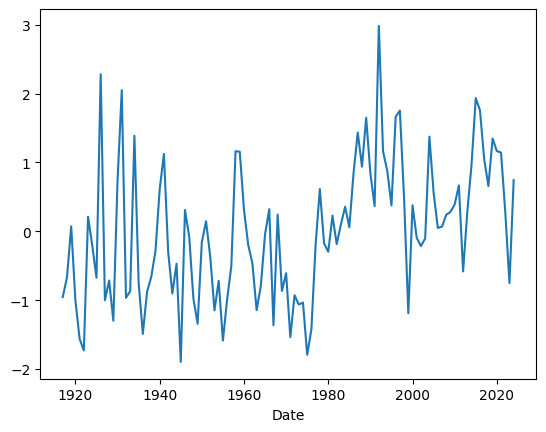

In [19]:
data['SURF_TEMP_C'].plot()

# Joining data

Process data

In [ ]:
species_of_interest = ['anchovy_northern',
                       'sardine_pacific',
                       'mackerel_pacific',
                       'mackerel_jack',
                       'squid_market',
                       'whiting_pacific']

pounds_filtered = grouped_pounds_renamed[[col for col in species_of_interest if col in grouped_pounds_renamed.columns]]
value_filtered = grouped_value_renamed[[col for col in species_of_interest if col in grouped_value_renamed.columns]]
larvae_filtered = grouped_larvae_renamed[[col for col in species_of_interest if col in grouped_larvae_renamed.columns]]

pounds_filtered = pounds_filtered.groupby(pounds_filtered.index.year).sum()
value_filtered = value_filtered.groupby(value_filtered.index.year).sum()
larvae_filtered = larvae_filtered.groupby(larvae_filtered.index.year).mean()

temp_filtered = grouped_temp.groupby(grouped_temp.index.year).mean()

Join

In [ ]:
# Ensure the index is integer years
for df in [pounds_filtered, value_filtered, larvae_filtered]:
    df.index = df.index.astype(int)

# Add suffixes to avoid duplicate column names
combined_california = pd.concat([
    pounds_filtered.add_suffix('_LANDINGS'),
    value_filtered.add_suffix('_VALUE'),
    larvae_filtered.add_suffix('_LARVAE'),
    temp_filtered
], axis=1).loc[1983:2018]

#combined_california = combined_california.diff().dropna()
combined_california = combined_california.apply(lambda x: np.sqrt(normalize(x, method=1)), axis=0)
#combined_california = combined_california.apply(lambda x: normalize(x, method=2), axis = 0)
#combined_california = combined_california.apply(lambda x: normalize(x, method=1), axis = 0)
combined_california

In [ ]:
# Assuming df is your DataFrame with time series as columns
skew_values = combined_california.skew()

# Print skewness for each column
print(skew_values)

In [ ]:
#combined_california.to_pickle("../../data_out/" + "combinedCalifornia" + "_annually.pkl")

# All species

In [7]:
# Load the Excel file
df = pd.read_excel("../../data/raw/CDFW/CDFW_landings_statewide.xlsx")

In [8]:
# Replace 'Confidential' with 0 and convert columns to numeric
df['Pounds'] = pd.to_numeric(df['Pounds'], errors='coerce').fillna(0).astype(int)
df['Value'] = pd.to_numeric(df['Value'], errors='coerce').fillna(0).astype(int)

# Create a datetime column for grouping
df['Date'] = pd.to_datetime(df[['Year', 'Month']].assign(DAY=1))

# Group by Date and Species Name and sum over all blocks
grouped_pounds = df.groupby(['Date', 'Species Name'])['Pounds'].sum().unstack(fill_value=0)
grouped_value = df.groupby(['Date', 'Species Name'])['Value'].sum().unstack(fill_value=0)

# Optional: sort Date index
grouped_pounds = grouped_pounds.sort_index()
grouped_value = grouped_value.sort_index()

# Reindex
grouped_pounds = grouped_pounds#.reset_index().rename_axis(None, axis=1)
grouped_value = grouped_value#.reset_index().rename_axis(None, axis=1)

grouped_pounds

Species Name,Abalone,"Abalone, black","Abalone, flat","Abalone, green","Abalone, pink","Abalone, pinto","Abalone, red","Abalone, threaded","Abalone, white",Agar,...,Turtle,Unspecified,Wahoo,"Whelk, Kellet's","Whitefish, ocean","Whiting, Pacific","Worms, marine","Wrasse, rock",Yellowtail,Zebraperch
Date,,,,,,,,,,,,,,,,,,,,,
1980-01-01,0,36851,0,5690,14264,0,36533,0,318,0,...,0,0,0,0,0,0,0,0,15396,0
1980-02-01,0,2954,0,831,394,0,0,0,0,0,...,0,0,0,0,0,0,0,0,34233,0
1980-03-01,0,33902,0,6498,21306,0,57107,0,0,0,...,0,0,0,0,0,0,0,0,15749,0
1980-04-01,0,19618,0,4715,20104,0,39090,0,0,0,...,0,0,0,0,0,0,0,0,20498,0
1980-05-01,0,30204,0,10229,17252,0,53606,0,0,0,...,0,0,0,0,0,0,0,0,11121,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-01,0,0,0,0,0,0,0,0,0,0,...,0,0,0,2956,1295,149,0,0,5897,0
2024-09-01,0,0,0,0,0,0,0,0,0,0,...,0,0,2971,2506,3216,88,0,0,1399,0
2024-10-01,0,0,0,0,0,0,0,0,0,0,...,0,0,0,5921,4641,0,0,0,975,0


In [9]:
# Step 1: Load your species-by-group mapping
species_key = pd.read_csv('../../data/CDFW_all_species_names_v1.csv')  # assumes columns 'common_name' and 'species_group'

# Step 2: Convert your wide landing dataframe (e.g., named `grouped_pounds`)
# where columns are species names, and rows are dates or time points
# Assume it's already loaded:
# grouped_pounds = pd.read_csv('your_landings.csv') or preloaded

# Step 3: Build a mapping from species name to group
species_to_group = species_key.set_index('common_name')['species_group'].to_dict()

# Step 4: Filter and match only species present in your dataframe
matching_species = [sp for sp in grouped_pounds.columns if sp in species_to_group]

# Step 5: Build a DataFrame with species grouped
grouped_landings = pd.DataFrame(index=grouped_pounds.index)

for species in matching_species:
    group = species_to_group[species]
    if group not in grouped_landings.columns:
        grouped_landings[group] = grouped_pounds[species].fillna(0)
    else:
        grouped_landings[group] += grouped_pounds[species].fillna(0)


# Set threshold
threshold = 0.7
n_rows = len(grouped_landings)

# Create boolean mask for columns that are nonzero more than 80% of the time
valid_columns = (grouped_landings != 0).sum() / n_rows > threshold

# Filter to keep only those columns
grouped_landings_all = grouped_landings.loc[:, valid_columns]

/tmp/ipykernel_1307909/2508133008.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  grouped_landings[group] = grouped_pounds[species].fillna(0)
/tmp/ipykernel_1307909/2508133008.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  grouped_landings[group] = grouped_pounds[species].fillna(0)
/tmp/ipykernel_1307909/2508133008.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat

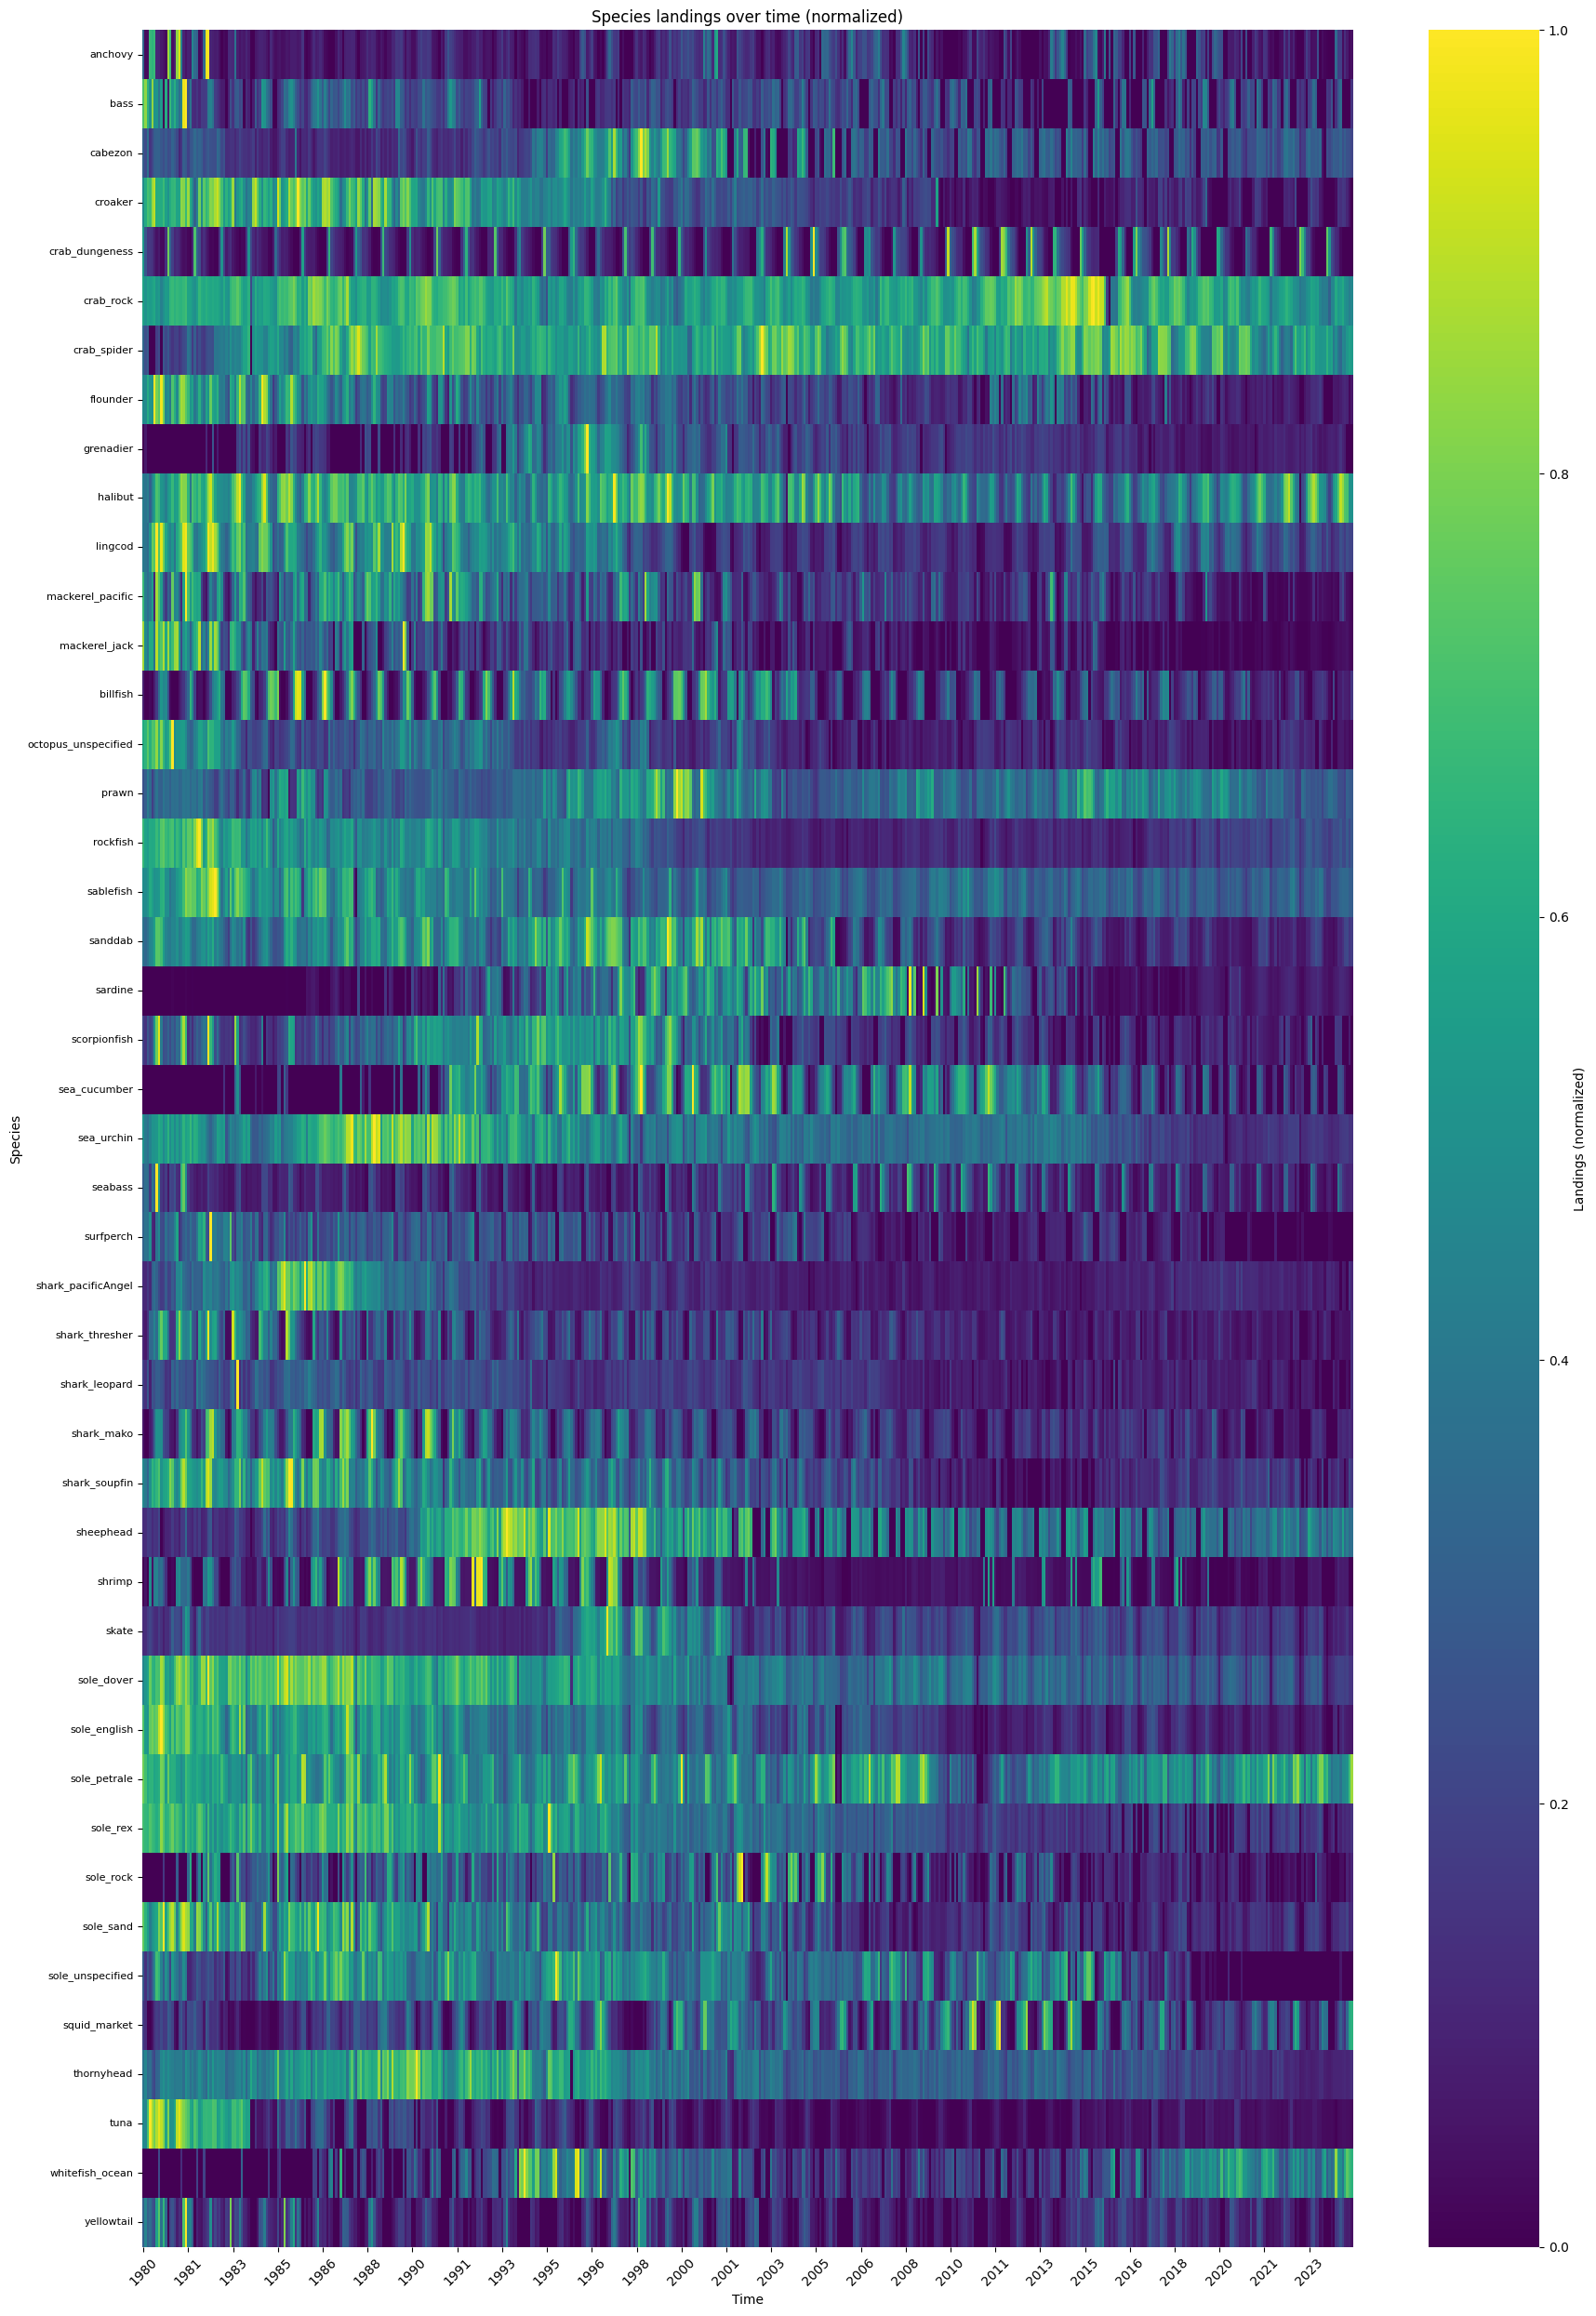

In [10]:
heatmap_data = grouped_landings_all.apply(lambda x: np.sqrt(normalize(x, method=1)), axis = 0)

# Transpose so species are rows and time is columns
heatmap_data = heatmap_data.T

# Plot
fig, ax = plt.subplots(1, sharex=True)
sns.heatmap(heatmap_data, cmap='viridis', cbar_kws={'label': 'Landings (normalized)'}, ax=ax, yticklabels=True)
ax.set_xlabel("Time")
ax.set_ylabel("Species")
ax.set_title("Species landings over time (normalized)")

# Format x-axis to show only the year
ax.set_xticklabels([label.get_text()[:4] for label in ax.get_xticklabels()], rotation=45)
ax.set_yticks(np.arange(heatmap_data.shape[0]) + 0.5)  # one tick per row
ax.set_yticklabels(heatmap_data.index, rotation=0, fontsize=8)  # or rotation=45, fontsize as needed

fig.set_size_inches(18, 25)
plt.tight_layout()
plt.show()

In [20]:
data_of_interest = grouped_landings_all

data_of_interest = pd.merge(data_of_interest, grouped_temp, left_index=True, right_index=True, how='inner')

In [ ]:
# Save dataset without processing (normalization)
data = data_of_interest

data.to_pickle("../../data_out/" + "cdfw_landingsALLunprocessed" + "_monthly.pkl")

In [ ]:
# Monthly
data = data_of_interest

#data = deseasonalize_anomalies_fixed_period(data, 'monthly')
#data = data.diff().dropna()
data = data.apply(lambda x: np.sqrt(normalize(x, method=1)), axis = 0)
#data = data.apply(lambda x: normalize(x, method=2), axis = 0)

data.to_pickle("../../data_out/" + "cdfw_landingsALL" + "_monthly.pkl")
#data.to_pickle("../../data_out/" + "cdfw_valueALL" + "_monthly.pkl")

In [21]:
# Seasonally
data = data_of_interest.copy()  # <-- this avoids the view vs. copy warning
data['quarter_start'] = data.index.map(reset_to_quarter_start)
data = data.groupby('quarter_start').sum()
data.index.name = 'Date'

#data.to_pickle("../../data_out/" + "cdfw_landingsALLunprocessed" + "_seasonally.pkl")

#data = data.diff().dropna()
data = data.apply(lambda x: np.sqrt(normalize(x, method=1)), axis=0)
#data = data.apply(lambda x: normalize(x, method=1), axis=0)
#data = data.apply(lambda x: normalize(x, method=2), axis=0)
data.index.name = 'Date'

data.to_pickle("../../data_out/" + "cdfw_landingsALL" + "_seasonally.pkl")
#data.to_pickle("../../data_out/" + "cdfw_valueALL" + "_seasonally.pkl")

In [ ]:
# Annually
data = data_of_interest
data = data.groupby(data.index.year).sum()

#data = data.diff().dropna()
data = data.apply(lambda x: np.sqrt(normalize(x, method=1)), axis = 0)
#data = data.apply(lambda x: normalize(x, method=2), axis = 0)

data.to_pickle("../../data_out/" + "cdfw_landingsALL" + "_annually.pkl")
#data.to_pickle("../../data_out/" + "cdfw_valueALL" + "_annually.pkl")

In [ ]:
# Annually, spring only
data = data_of_interest
data = data[data.index.month == 4]
data = data.groupby(data.index.year).sum()

#data = data.diff().dropna()
#data = data.apply(lambda x: np.sqrt(normalize(x, method=1)), axis = 0)
data = data.apply(lambda x: normalize(x, method=2), axis = 0)

#data.to_pickle("../../data_out/" + "cdfw_landingsALL" + "_annually.pkl")
#data.to_pickle("../../data_out/" + "cdfw_valueALL" + "_annually.pkl")

In [ ]:
data['crab_rock'].plot()

# Species management plans

In [ ]:
# Load the Excel file
df = pd.read_excel("../../data/raw/CDFW/CDFW_landings_statewide.xlsx")

In [ ]:
# Replace 'Confidential' with 0 and convert columns to numeric
df['Pounds'] = pd.to_numeric(df['Pounds'], errors='coerce').fillna(0).astype(int)
df['Value'] = pd.to_numeric(df['Value'], errors='coerce').fillna(0).astype(int)

# Create a datetime column for grouping
df['Date'] = pd.to_datetime(df[['Year', 'Month']].assign(DAY=1))

# Group by Date and Species Name and sum over all blocks
grouped_pounds = df.groupby(['Date', 'Species Name'])['Pounds'].sum().unstack(fill_value=0)
grouped_value = df.groupby(['Date', 'Species Name'])['Value'].sum().unstack(fill_value=0)

# Optional: sort Date index
grouped_pounds = grouped_pounds.sort_index()
grouped_value = grouped_value.sort_index()

# Reindex
grouped_pounds = grouped_pounds#.reset_index().rename_axis(None, axis=1)
grouped_value = grouped_value#.reset_index().rename_axis(None, axis=1)

grouped_pounds

In [ ]:
species_per_management_plan = df.groupby('Species Management')['Species Name'].nunique()

# Plot the results
plt.figure(figsize=(10, 6))
species_per_management_plan.plot(kind='bar', color='skyblue')
plt.title('Number of Species in Each Management Plan')
plt.xlabel('Species Management Plan')
plt.ylabel('Number of Species')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
# Group species by management plan
species_by_plan = (
    df.groupby('Species Management')['Species Name']
      .unique()
      .apply(sorted)   # optional: sort alphabetically
      .to_dict()
)

# Print in readable format
for plan, species in species_by_plan.items():
    print(f"\n📘 {plan} ({len(species)} species):")
    for sp in species:
        print(f"  - {sp}")

In [ ]:
# Assuming your DataFrame is named `df` and has columns:
# 'Species Management', 'Species Name', 'Pounds'

df['Pounds'] = pd.to_numeric(df['Pounds'], errors='coerce').fillna(0).astype(int)
df['Value'] = pd.to_numeric(df['Value'], errors='coerce').fillna(0).astype(int)

# Step 1: Total landings by species within each plan
species_totals = (
    df.groupby(['Species Management', 'Species Name'])['Pounds']
      .sum()
      .reset_index()
)

# Step 2: Total landings per management plan
plan_totals = (
    species_totals.groupby('Species Management')['Pounds']
    .sum()
    .rename('TotalGroupPounds')
    .reset_index()
)

# Step 3: Merge to compute percentage
merged = pd.merge(species_totals, plan_totals, on='Species Management')
merged['Percent'] = 100 * merged['Pounds'] / merged['TotalGroupPounds']

# Step 4: Get top 3 species by Pounds for each management plan
top_species_by_plan = (
    merged.sort_values(['Species Management', 'Pounds'], ascending=[True, False])
          .groupby('Species Management')
          .head(3)
)

# Optional: sort for display
top_species_by_plan = top_species_by_plan.sort_values(['Species Management', 'Pounds'], ascending=[True, False])

# Print or export the results
top_species_by_plan

In [ ]:
# Replace 'Confidential' with 0 and convert columns to numeric
df['Pounds'] = pd.to_numeric(df['Pounds'], errors='coerce').fillna(0).astype(int)
df['Value'] = pd.to_numeric(df['Value'], errors='coerce').fillna(0).astype(int)

# Create a datetime column for grouping
df['Date'] = pd.to_datetime(df[['Year', 'Month']].assign(DAY=1))

# Group by Date and Species Name and sum over all blocks
grouped_pounds = df.groupby(['Date', 'Species Management'])['Pounds'].sum().unstack(fill_value=0)
grouped_value = df.groupby(['Date', 'Species Management'])['Value'].sum().unstack(fill_value=0)

# Optional: sort Date index
grouped_pounds = grouped_pounds.sort_index()
grouped_value = grouped_value.sort_index()

# Reindex
grouped_pounds = grouped_pounds#.reset_index().rename_axis(None, axis=1)
grouped_value = grouped_value#.reset_index().rename_axis(None, axis=1)

grouped_pounds

In [ ]:
heatmap_data = grouped_pounds.apply(lambda x: np.sqrt(normalize(x, method=1)), axis = 0)

# Transpose so species are rows and time is columns
heatmap_data = heatmap_data.T

# Plot
fig, ax = plt.subplots(1, sharex=True)
sns.heatmap(heatmap_data, cmap='viridis', cbar_kws={'label': 'Landings (normalized)'}, ax=ax, yticklabels=True)
ax.set_xlabel("Time")
ax.set_ylabel("Species")
ax.set_title("Species landings over time (normalized)")

# Format x-axis to show only the year
ax.set_xticklabels([label.get_text()[:4] for label in ax.get_xticklabels()], rotation=45)
ax.set_yticks(np.arange(heatmap_data.shape[0]) + 0.5)  # one tick per row
ax.set_yticklabels(heatmap_data.index, rotation=0, fontsize=8)  # or rotation=45, fontsize as needed

fig.set_size_inches(18, 10)
plt.tight_layout()
plt.show()

In [ ]:
data_of_interest = grouped_pounds.drop(columns=["Algae", "Other"])

data_of_interest.columns = (
    data_of_interest.columns
    .str.lower() # all lower-case
    .str.replace(r'[^0-9a-z]+', '_', regex=True) # spaces, (), /, etc. → _
    .str.strip('_') # trim leading/trailing _
    )

data_of_interest = pd.merge(data_of_interest, grouped_temp, left_index=True, right_index=True, how='inner')

print(data_of_interest.columns.tolist())

In [ ]:
# Monthly
data = data_of_interest

#data = data.diff().dropna()
data = deseasonalize_by_index_period(data, 12)
#data = data.apply(lambda x: np.sqrt(normalize(x, method=1)), axis = 0)
#data = data.apply(lambda x: normalize(x, method=2), axis = 0)

#data.to_pickle("../../data_out/" + "management_landings" + "_monthly.pkl")
#data.to_pickle("../../data_out/" + "management_value" + "_monthly.pkl")

In [ ]:
# Seasonally
data = data_of_interest.copy()  # <-- this avoids the view vs. copy warning
data['quarter_start'] = data.index.map(reset_to_quarter_start)
data = data.groupby('quarter_start').sum()

data = data.diff().dropna()
#data = deseasonalize_by_index_period(data, 4)
#data = data.apply(lambda x: np.sqrt(normalize(x, method=1)), axis=0)
#data = data.apply(lambda x: normalize(x, method=1), axis=0)
data = data.apply(lambda x: normalize(x, method=2), axis=0)
data.index.name = 'Date'

data.to_pickle("../../data_out/" + "management_landings" + "_seasonally.pkl")
#data.to_pickle("../../data_out/" + "management_value" + "_seasonally.pkl")

In [ ]:
# Annually
data = data_of_interest
data = data.groupby(data.index.year).sum()

#data = data.diff().dropna()
#data = data.apply(lambda x: np.sqrt(normalize(x, method=1)), axis = 0)
#data = data.apply(lambda x: normalize(x, method=2), axis = 0)

data.to_pickle("../../data_out/" + "management_landings" + "_annually.pkl")
#data.to_pickle("../../data_out/" + "management_value" + "_annually.pkl")

In [ ]:
# Annually, spring only
data = data_of_interest
data = data[data.index.month == 4]
data = data.groupby(data.index.year).sum()

#data = data.diff().dropna()
data = data.apply(lambda x: np.sqrt(normalize(x, method=1)), axis = 0)
#data = data.apply(lambda x: normalize(x, method=2), axis = 0)

#data.to_pickle("../../data_out/" + "management_landings" + "_annually.pkl")
#data.to_pickle("../../data_out/" + "management_value" + "_annually.pkl")

In [ ]:
data['SURF_TEMP_C'].plot()

# Per species management plan

In [ ]:
# convenience: strip any leading/trailing spaces that sneak in
df['Species Management'] = df['Species Management'].str.strip()
df['Species Name']       = df['Species Name'].str.strip()
# ------------------------------------------------------

def get_species_by_plan(df, plan):
    # Allow either a single string or an iterable
    if isinstance(plan, str):
        mask = df['Species Management'] == plan
    else:
        mask = df['Species Management'].isin(plan)

    species = (
        df.loc[mask, 'Species Name']
        .dropna()
        .unique()
    )
    return sorted(species)

pelagic_plans = ['Highly Migratory Species (HMS)',
                 'Coastal Pelagic Species (CPS)']
pelagic_species = get_species_by_plan(df, pelagic_plans)

groundfish_plan = ['Groundfish']
groundfish_species = get_species_by_plan(df, groundfish_plan)

In [ ]:
data_of_interest = grouped_pounds[groundfish_species]

heatmap_data = data_of_interest.apply(lambda x: np.sqrt(normalize(x, method=1)), axis = 0)

# Transpose so species are rows and time is columns
heatmap_data = heatmap_data.T

# Plot
fig, ax = plt.subplots(1, sharex=True)
sns.heatmap(heatmap_data, cmap='viridis', cbar_kws={'label': 'Landings (normalized)'}, ax=ax, yticklabels=True)
ax.set_xlabel("Time")
ax.set_ylabel("Species")
ax.set_title("Species landings over time (normalized)")

# Format x-axis to show only the year
ax.set_xticklabels([label.get_text()[:4] for label in ax.get_xticklabels()], rotation=45)
ax.set_yticks(np.arange(heatmap_data.shape[0]) + 0.5)  # one tick per row
ax.set_yticklabels(heatmap_data.index, rotation=0, fontsize=8)  # or rotation=45, fontsize as needed

fig.set_size_inches(18, 10)
plt.tight_layout()
plt.show()